### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo. 

El dataset con el que vamos a trabajar en este notebook contiene alrededor de **300 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**DIARIAS**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Es decir, partimos de ventas diarias y vamos a tener que <u>**agrupar nuestras ventas por mes**</u> antes de crear variables o entrenar el modelo.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
### Índice

[Imports del notebook](#imports_notebook)<br>
[Helpers Time Series](#helpers)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Agrupación de las ventas por mes (**CORE IDEA**)](#monthly_agg)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [5381]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5382]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5383]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

Numpy version 1.23.5
Pandas version 1.5.3
XGBoost version 1.7.5


In [5384]:
### GLOBAL_VARIABLES
DATA_PATH = r"G:\Mi unidad\Master Data Science\07_Time Series\Data Source"
FILE_NAME = "sales_train_merged.csv"

# CWD = os.getcwd()
# DATA_PATH = os.path.join(CWD, "data")
# FILE_NAME = "ts_kaggle_sales_train_merged.csv"

TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

ORDER_COLUMNS = [
    'DATE',
    'UNIQUE_ID',
    'CITY_NAME',
    'CITY_ID',
    'SHOP_NAME',
    'SHOP_ID',
    'ITEM_CATEGORY_NAME',
    'ITEM_CATEGORY_ID',
    'ITEM_NAME',
    'ITEM_ID',
    'ITEM_PRICE',
    'SALES'
]

In [5385]:
# RMSE

In [5386]:
y_true = [10, 9, 8, 11, 12, 14]
y_pred = [8, 9, 12, 7, 10, 14]

In [5387]:
(10 - 8) ** 2

4

In [5388]:
np.sqrt((11 - 4) ** 2)

7.0

<a id='helpers'></a>
### Helpers Time Series
[Volver al índice](#index)

En este apartado definimos varias funciones auxiliares que utilizaremos a lo largo del notebook.

In [5389]:
def load_data(path_data_file):
    '''
    Loads the csv file for training.
    '''
    df = pd.read_csv(path_data_file, index_col = 0)
    
    df = preprocess_df(df)
    
    return df

In [5390]:
def preprocess_df(df):
    '''
    Preprocess df: upper columns, str date to datetime etc.
    '''
    df.columns = map(str.upper, df.columns)
    df["DATE"] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")
    
    df["CITY_ID"] = OrdinalEncoder().fit_transform(df[["CITY"]])
    
    df.rename(columns = {"CITY":"CITY_NAME", "ITEM_CNT_DAY":"SALES"}, inplace = True)
    df = df[ORDER_COLUMNS]
    
    return df

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comÇenzar con el EDA.

In [5391]:
df = load_data(path_data_file = TRAIN_CSV_PATH)
df.sample(5)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
56512,2014-10-08,42-5821,San Petersburgo,14.0,"San Petersburgo TK ""Nevsky Centro""",42,Las tarjetas de pago - PSN,35,Suscripción de PlayStation Plus 3 meses: Tarje...,5821,799.000000,2.0
58610,2014-11-05,5-17717,Vlogda,20.0,"Vlogda SEC ""Mermelada""",5,Herramientas de sistema,79,Recibir fondos para 1c-online,17717,514.666667,3.0
42838,2014-06-01,18-3732,Krasnoyarsk,5.0,"Krasnoyarsk SC ""Junio""",18,Juegos - PS3,19,"Grand Theft Auto V [PS3, subtítulos rusos]",3732,2599.000000,2.0
29691,2014-01-10,24-2808,Moscú,7.0,"Moscú TK ""Budenovsky"" (pav.K7)",24,Juegos PC - Standard Edition,30,"Diablo III [PC, JEWEL, versión rusa]",2808,999.000000,1.0
46070,2014-07-07,5-20949,Vlogda,20.0,"Vlogda SEC ""Mermelada""",5,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.000000,4.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [5392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87963 entries, 0 to 87962
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                87963 non-null  datetime64[ns]
 1   UNIQUE_ID           87963 non-null  object        
 2   CITY_NAME           87963 non-null  object        
 3   CITY_ID             87963 non-null  float64       
 4   SHOP_NAME           87963 non-null  object        
 5   SHOP_ID             87963 non-null  int64         
 6   ITEM_CATEGORY_NAME  87963 non-null  object        
 7   ITEM_CATEGORY_ID    87963 non-null  int64         
 8   ITEM_NAME           87963 non-null  object        
 9   ITEM_ID             87963 non-null  int64         
 10  ITEM_PRICE          87963 non-null  float64       
 11  SALES               87963 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 8.7+ MB


<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido. 

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con unas pocas columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar nuestro primer modelo.**</u> 

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por "notebook funcional" entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Ver cuantas Series Temporales tenemos en el dataset.
2. Hacer un check de si tenemos todas las fechas históricas en el dataset.
3. Generar las fechas que puedan estar missing.
4. Tratar los nulos.
5. Crear algunas variables rápidas para el entrenamiento.
6. Entrenar el algoritmo.
7. Evaluar el modelo.
8. Hacer el submit a Kaggle.

Empecemos:

Tenemos un total de 299 Series Temporales en el dataset:

In [5393]:
df["UNIQUE_ID"].nunique()

299

Veamos cuales son las fechas min y max de nuestro dataset:

In [5394]:
MIN_DATE = df["DATE"].min()
MAX_DATE = df["DATE"].max()

In [5395]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-01 00:00:00
Max date is 2015-09-30 00:00:00


<a id='monthly_agg'></a>
### Agrupación de las ventas por mes
[Volver al índice](#index)

En esta competición nos piden que hagamos el predict de las ventas totales del mes de Octubre'2015 para cada ITEM_ID y SHOP_ID.

No obstante, si miramos el dataset con detenimiento, veremos que las ventas reportadas vienen por día. Ahora mismo tenemos 2 opciones: 

1. Podemos entrenar un modelo con las ventas diarias, predecir 30 días y luego sumar las 30 predicciones y obtener el valor para Octubre'2015.
2. Agrupar las ventas por mes, entrenar un modelo con las ventas mensuales y hacer 1 predict (mes de Octubre'2015).

Claramente la segunda opción es mucho más sencilla: básicamente me permite enfocar un problema de Series Temporales Multivariante como un problema de Regresión (1 predicción a futuro). Por este motivo vamos a seguir este enfoque.

Nota: Si observamos bien, UNIQUE_ID = SHOP_ID + ITEM_ID.

In [5396]:
df.sample(5)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
81215,2015-07-06,11-20949,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,3.59,2.0
38534,2014-05-25,25-20949,Moscú,7.0,"Moscú SEC ""Atrium""",25,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.00,13.0
31244,2014-02-01,24-20949,Moscú,7.0,"Moscú TK ""Budenovsky"" (pav.K7)",24,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.00,8.0
39267,2014-05-03,28-20949,Moscú,7.0,"centro comercial de Moscú ""MEGA Teply Stan"" II",28,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.00,23.0
76030,2015-04-25,15-3732,Kaluga,2.0,"Kaluga SEC ""Siglo XXI""",15,Juegos - PS3,19,"Grand Theft Auto V [PS3, subtítulos rusos]",3732,3399.00,3.0


A continuación vamos a agrupar las ventas diarias por mes, en función de cada shop_id e item_id (groupby).

Dado que vamos a entrenar nuestro modelo con variables mensuales, aprovechamos la operación para constuir un total de 5 variables: 

1. Ventas totales
2. Ingresos totales (precio x cantidad)
3. Días únicos que tuvieron ventas
4. Total transacciones del mes 
5. Precio medio del mes

In [5397]:
df["REVENUE"] = df["ITEM_PRICE"] * df["SALES"]
df["UNIQUE_DAYS_WITH_SALES"] = df["DATE"]
df["TOTAL_TRANSACTIONS"] = df["SALES"]

En las clases anteriores hemos aprendido a utilizar el [pandas groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html).

Cuando trabajamos con Series Temporales y necesitamos agrupar las Series Temporales por día, semana, mes o año, podemos utilizar el groupby pero es mejor utilizar el [pandas resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html).

La síntaxis del pandas resample es muy sencilla, vamos a ver un ejemplo de como podríamos agrupar las ventas por semana.

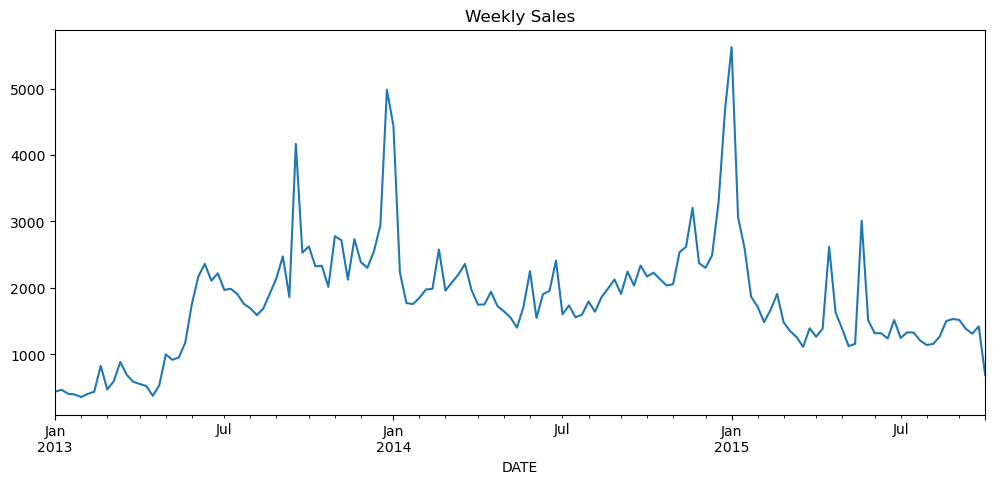

In [5398]:
# Para utilizar el resample
# 1. La fecha debe estar en el índice
# 2. Debemos llamar el método resample y pasarle un regla:
#    D -> Daily
#    W -> Weekly
#    M -> Monthly
#    Y -> Yearly

df.set_index("DATE").resample("W")["SALES"].sum().plot(figsize = (12, 5), title = "Weekly Sales");

En el código anterior, hemos hecho el resample de todas las ventas.

Pero nosotros debemos tener en cuenta el item_id y el shop_id antes de hacer el resample.

Veamos como podemos combinar el groupby con resample.

In [5399]:
# Implement in class

df_monthly_agg = df.set_index("DATE").groupby(["UNIQUE_ID"]).resample("M").agg(
    {
        "SALES":np.sum,
        "REVENUE":np.sum,
        "UNIQUE_DAYS_WITH_SALES":lambda dates: len(set(dates)),
        "TOTAL_TRANSACTIONS":len,
        "ITEM_PRICE":np.mean
    }
).rename(
    columns = {
        "SALES":"MONTHLY_SALES",
        "REVENUE":"MONTHLY_REVENUE",
        "ITEM_PRICE":"MONTHLY_MEAN_PRICE"
    }
).reset_index()

In [5400]:
df_monthly_agg["CHECK"] = df_monthly_agg["UNIQUE_DAYS_WITH_SALES"] == df_monthly_agg["TOTAL_TRANSACTIONS"]

In [5401]:
df_monthly_agg[df_monthly_agg["CHECK"] == False].sample(5)

,UNIQUE_ID,DATE,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
1579,24-2808,2013-04-30,17.0,15833.0,9,11,963.015152,False
1759,24-7856,2013-01-31,11.0,8789.0,9,10,799.000000,False
1728,24-5822,2013-03-31,15.0,15735.0,10,13,1049.000000,False
1546,24-2445,2013-04-30,32.0,19167.5,13,18,598.990741,False
1576,24-2808,2013-01-31,29.0,27970.5,18,20,963.991667,False


A continuación vamos a tener que comprobar si tenemos todas las fechas en nuestro dataset o no.

Dado que nuestro dataset va desde Enero'13 - Septiembre'15, son un total de 33 meses.

In [5402]:
check_months = df_monthly_agg.groupby("UNIQUE_ID").size()
check_months.sample(3)

UNIQUE_ID
42-5823     33
31-17717    33
58-20949    28
dtype: int64

In [5403]:
check_months[check_months != 33].shape

(173,)

Tenemos un total de 173 Series Temporales incompletas (es decir, les falta por lo menos 1 mes de registros).

El motivo de estos, es que sólo tenemos las ventas reportadas. Si un día o en un mes no se producen ventas, no tenemos estos registros en nuestro df original.

A continuación vamos a generar un dataframe con todos los registros históricos y también con el mes de Octubre'2015 (mes de predict).

In [5404]:
# generamos un rango con todas las fechas incluídas en el predict (Octubre'2015)
DATE_PREDICTION = np.datetime64("2015-10-31")
date_range = pd.date_range(MIN_DATE, DATE_PREDICTION, freq = "M")
date_range

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31'],
              dtype='datetime64[ns]', freq='M')

In [5405]:
# sacamos todas las combinaciones únicas que tenemos en nuestro dataframe (299 combinaciones, una por cada serie temporal)
unique_id = sorted(df_monthly_agg["UNIQUE_ID"].unique())
unique_id[:3]

['11-20949', '11-4181', '12-11365']

In [5406]:
len(unique_id)

299

Generamos todas las combinaciones entre meses e unique_id.

Es decir, necesitamos sacar un [producto cartesiano](https://es.wikipedia.org/wiki/Producto_cartesiano).

In [5407]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["DATE", "UNIQUE_ID"])
len(cartesian_product)

10166

In [5408]:
# 10166 son 34 meses por todas las combinaciones de unique_id
34 * 299

10166

Cruzamos nuestro producto cartesiano con el dataframe agrupado por meses y que contiene las ventas históricas.

In [5409]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

print(full_df.shape)

full_df = pd.merge(full_df, df_monthly_agg, on = ['DATE','UNIQUE_ID'], how = 'left')

print(full_df.shape)

(10166, 2)
(10166, 8)


In [5410]:
full_df.sample(5)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
7667,2015-02-28,42-5822,30.0,32370.00,12.0,12.0,1082.333333,True
8063,2015-03-31,6-17717,37.0,50479.00,16.0,16.0,1438.489583,True
8662,2015-05-31,6-20949,10.0,50.00,8.0,8.0,5.000000,True
8238,2015-04-30,31-6497,9.0,13410.99,8.0,8.0,1492.498750,True
3957,2014-02-28,25-2308,5.0,1495.00,4.0,4.0,299.000000,True


Hemos agrupado nuestras ventas, pero hemos perdido algo de información del dataset original.

Vamos a enriquecer nuestro full_df con más información.

In [5411]:
add_info = df[
    ["UNIQUE_ID", "CITY_NAME", "CITY_ID", "SHOP_NAME", "SHOP_ID", "ITEM_CATEGORY_NAME", "ITEM_CATEGORY_ID", "ITEM_NAME", "ITEM_ID"]
].drop_duplicates()

add_info.head(3)

,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,25-2574,Moscú,7.0,"Moscú SEC ""Atrium""",25,Música - CD de la producción local,55,Del Rey Lana Nació para morir la edición de Pa...,2574
10,25-2808,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Diablo III [PC, JEWEL, versión rusa]",2808
28,25-2308,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Call of Duty: Black Ops II [PC, Jewel, versión...",2308


In [5412]:
add_info.shape

(299, 9)

In [5413]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = add_info,
    how = "left",
    on = "UNIQUE_ID"
)

print(full_df.shape)

(10166, 8)
(10166, 16)


<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [5414]:
full_df

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,2013-01-31,11-20949,NaN,NaN,NaN,NaN,NaN,NaN,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949
1,2013-01-31,11-4181,NaN,NaN,NaN,NaN,NaN,NaN,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181
2,2013-01-31,12-11365,35.0,43300.0,12.0,12.0,1511.512626,True,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (EMS),11365
3,2013-01-31,12-11369,42.0,21220.0,12.0,12.0,572.715278,True,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (correo),11369
4,2013-01-31,12-11370,62.0,30750.0,16.0,16.0,699.776786,True,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (en Moscú),11370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10161,2015-10-31,6-5823,NaN,NaN,NaN,NaN,NaN,NaN,Voronezh,22.0,"Voronezh (Plekhanovskaya, 13)",6,Las tarjetas de pago - PSN,35,PlayStation Store Replenishment Wallet: Mapa d...,5823
10162,2015-10-31,6-7856,NaN,NaN,NaN,NaN,NaN,NaN,Voronezh,22.0,"Voronezh (Plekhanovskaya, 13)",6,Juegos PC - Otras publicaciones,28,Mundo de Warcraft. Tiempo de juego Mapa de pag...,7856
10163,2015-10-31,7-17717,NaN,NaN,NaN,NaN,NaN,NaN,Voronezh,22.0,"Voronezh SEC ""Maksimir""",7,Herramientas de sistema,79,Recibir fondos para 1c-online,17717
10164,2015-10-31,7-20949,NaN,NaN,NaN,NaN,NaN,NaN,Voronezh,22.0,"Voronezh SEC ""Maksimir""",7,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949


In [5415]:
full_df.drop(["CHECK"], axis = 1, inplace = True)

In [5416]:
full_df.isnull().sum()

DATE                         0
UNIQUE_ID                    0
MONTHLY_SALES             1420
MONTHLY_REVENUE           1420
UNIQUE_DAYS_WITH_SALES    1420
TOTAL_TRANSACTIONS        1420
MONTHLY_MEAN_PRICE        1700
CITY_NAME                    0
CITY_ID                      0
SHOP_NAME                    0
SHOP_ID                      0
ITEM_CATEGORY_NAME           0
ITEM_CATEGORY_ID             0
ITEM_NAME                    0
ITEM_ID                      0
dtype: int64

In [5417]:
full_df["MONTHLY_SALES"].fillna(0, inplace = True)
full_df["MONTHLY_REVENUE"].fillna(0, inplace = True)
full_df["UNIQUE_DAYS_WITH_SALES"].fillna(0, inplace = True)
full_df["TOTAL_TRANSACTIONS"].fillna(0, inplace = True)

In [5418]:
# implementar en clase diferentes estrategias de imputación
sample_series = full_df[full_df["UNIQUE_ID"] == "7-17717"][["DATE", "UNIQUE_ID", "MONTHLY_MEAN_PRICE"]]
sample_series

,DATE,UNIQUE_ID,MONTHLY_MEAN_PRICE
296,2013-01-31,7-17717,449.000000
595,2013-02-28,7-17717,428.000000
894,2013-03-31,7-17717,619.000000
1193,2013-04-30,7-17717,390.000000
1492,2013-05-31,7-17717,599.000000
1791,2013-06-30,7-17717,NaN
2090,2013-07-31,7-17717,281.745000
2389,2013-08-31,7-17717,239.400000
2688,2013-09-30,7-17717,333.000000
2987,2013-10-31,7-17717,499.000000


In [5419]:
full_df["MONTHLY_MEAN_PRICE"] = full_df.groupby("UNIQUE_ID")["MONTHLY_MEAN_PRICE"].apply(
    lambda series: series.backfill().ffill()
)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_96936\3370454299.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  full_df["MONTHLY_MEAN_PRICE"] = full_df.groupby("UNIQUE_ID")["MONTHLY_MEAN_PRICE"].apply(


In [5420]:
del df, cartesian_product, unique_id, date_range, add_info, sample_series, check_months

<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Ahora por fin tenemos un full_df con todos los registros y con los valores imputados.

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [5421]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2)
    plot_pacf(x = y, ax = ax3)

    plt.suptitle(t = title, fontsize = 20)

In [5422]:
y = full_df.set_index("DATE").resample("M")["MONTHLY_SALES"].sum()

c:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


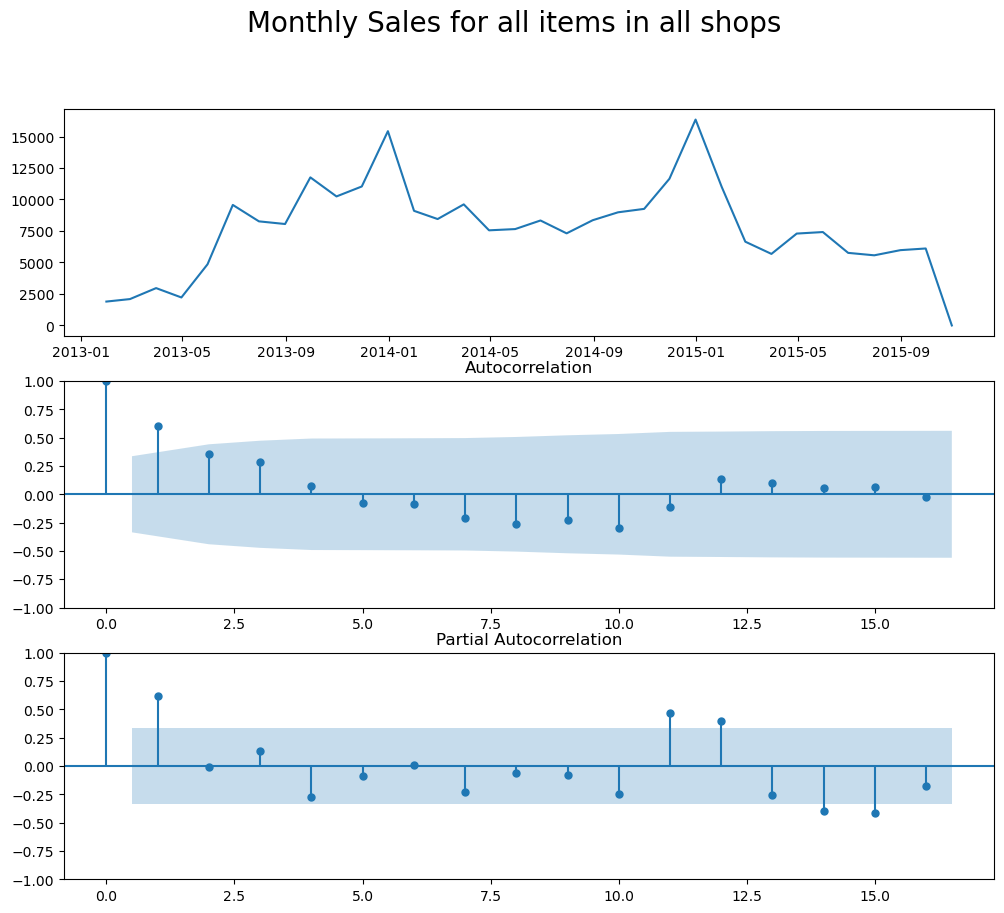

In [5423]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: 299 Series Temporales diferentes tendríamos que entrenar 299 ARIMAs. En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 299 Series Temporales de manera individual para ver su comportamiento.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

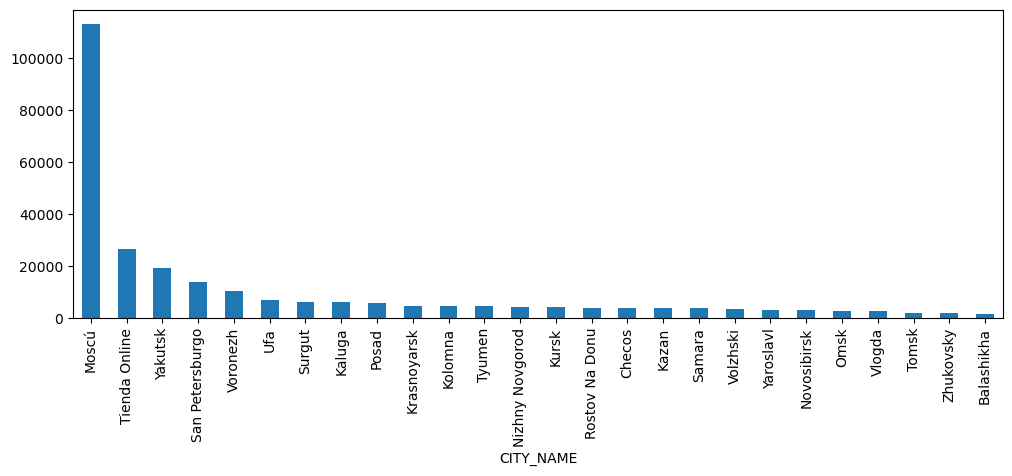

In [5424]:
(
    full_df.
    groupby(["CITY_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

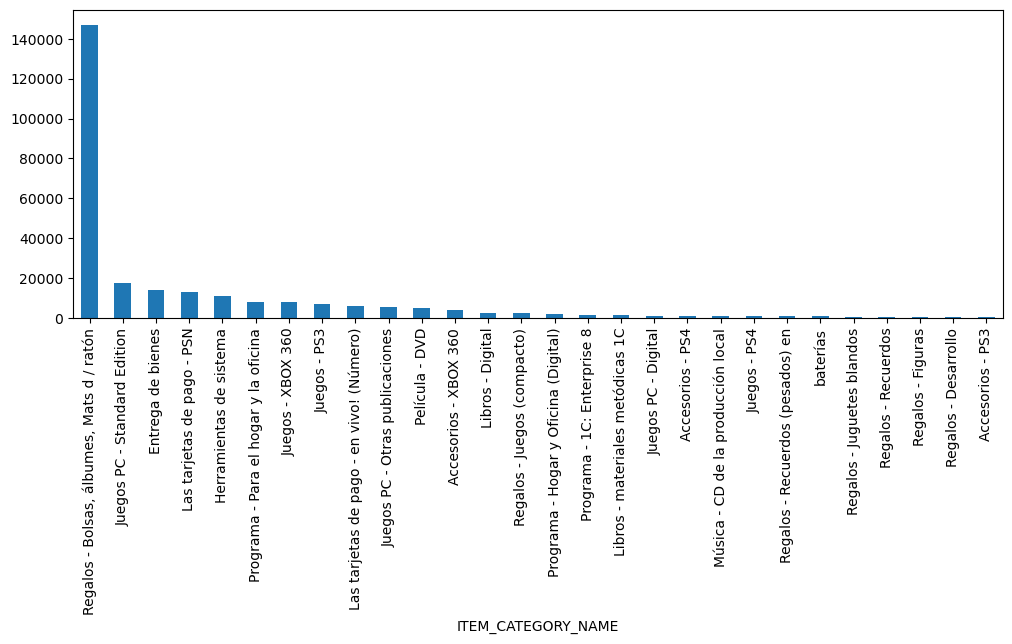

In [5425]:
(
    full_df.
    groupby(["ITEM_CATEGORY_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [5426]:
full_df.head()

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,2013-01-31,11-20949,0.0,0.0,0.0,0.0,3.000000,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949
1,2013-01-31,11-4181,0.0,0.0,0.0,0.0,707.000000,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181
2,2013-01-31,12-11365,35.0,43300.0,12.0,12.0,1511.512626,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (EMS),11365
3,2013-01-31,12-11369,42.0,21220.0,12.0,12.0,572.715278,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (correo),11369
4,2013-01-31,12-11370,62.0,30750.0,16.0,16.0,699.776786,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (en Moscú),11370


In [5427]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10166 entries, 0 to 10165
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    10166 non-null  datetime64[ns]
 1   UNIQUE_ID               10166 non-null  object        
 2   MONTHLY_SALES           10166 non-null  float64       
 3   MONTHLY_REVENUE         10166 non-null  float64       
 4   UNIQUE_DAYS_WITH_SALES  10166 non-null  float64       
 5   TOTAL_TRANSACTIONS      10166 non-null  float64       
 6   MONTHLY_MEAN_PRICE      10166 non-null  float64       
 7   CITY_NAME               10166 non-null  object        
 8   CITY_ID                 10166 non-null  float64       
 9   SHOP_NAME               10166 non-null  object        
 10  SHOP_ID                 10166 non-null  int64         
 11  ITEM_CATEGORY_NAME      10166 non-null  object        
 12  ITEM_CATEGORY_ID        10166 non-null  int64 

In [5428]:
full_df["CITY_ID"] = full_df["CITY_ID"].astype(int)

In [5429]:
full_df["UNIQUE_ID_2"] = full_df["CITY_ID"].astype(str) + "-" + full_df["SHOP_ID"].astype(str) + "-" + full_df["ITEM_CATEGORY_ID"].astype(str) + "-" + full_df["ITEM_ID"].astype(str)
full_df.head(3)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,UNIQUE_ID_2
0,2013-01-31,11-20949,0.0,0.0,0.0,0.0,3.000000,Zhukovsky,25,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,25-11-71-20949
1,2013-01-31,11-4181,0.0,0.0,0.0,0.0,707.000000,Zhukovsky,25,Zhukovsky calle. 39m² Chkalov,11,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181,25-11-75-4181
2,2013-01-31,12-11365,35.0,43300.0,12.0,12.0,1511.512626,Tienda Online,16,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (EMS),11365,16-12-9-11365


In [5430]:
full_df["UNIQUE_ID_3"] =full_df["SHOP_ID"].astype(str) + "-" + full_df["ITEM_CATEGORY_ID"].astype(str) + "-" + full_df["ITEM_ID"].astype(str)
full_df.head(3)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,UNIQUE_ID_2,UNIQUE_ID_3
0,2013-01-31,11-20949,0.0,0.0,0.0,0.0,3.000000,Zhukovsky,25,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,25-11-71-20949,11-71-20949
1,2013-01-31,11-4181,0.0,0.0,0.0,0.0,707.000000,Zhukovsky,25,Zhukovsky calle. 39m² Chkalov,11,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181,25-11-75-4181,11-75-4181
2,2013-01-31,12-11365,35.0,43300.0,12.0,12.0,1511.512626,Tienda Online,16,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (EMS),11365,16-12-9-11365,12-9-11365


In [5431]:
full_df.columns.to_list()

['DATE',
 'UNIQUE_ID',
 'MONTHLY_SALES',
 'MONTHLY_REVENUE',
 'UNIQUE_DAYS_WITH_SALES',
 'TOTAL_TRANSACTIONS',
 'MONTHLY_MEAN_PRICE',
 'CITY_NAME',
 'CITY_ID',
 'SHOP_NAME',
 'SHOP_ID',
 'ITEM_CATEGORY_NAME',
 'ITEM_CATEGORY_ID',
 'ITEM_NAME',
 'ITEM_ID',
 'UNIQUE_ID_2',
 'UNIQUE_ID_3']

In [5432]:
ORDER_COLUMNS=['DATE',
 'UNIQUE_ID',
 'UNIQUE_ID_2',
 'UNIQUE_ID_3',
 'ITEM_ID',
 'ITEM_NAME',
  'SHOP_ID',
 'SHOP_NAME',
 'ITEM_CATEGORY_ID',
 'ITEM_CATEGORY_NAME',
 'CITY_ID',
 'CITY_NAME',
 'MONTHLY_SALES',
 'MONTHLY_REVENUE',
 'UNIQUE_DAYS_WITH_SALES',
 'TOTAL_TRANSACTIONS',
 'MONTHLY_MEAN_PRICE'
]

In [5433]:
full_df=full_df[ORDER_COLUMNS]
full_df.head()

,DATE,UNIQUE_ID,UNIQUE_ID_2,UNIQUE_ID_3,ITEM_ID,ITEM_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,CITY_ID,CITY_NAME,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE
0,2013-01-31,11-20949,25-11-71-20949,11-71-20949,20949,Paquete corporativo Mike 1C Interés blanco (34...,11,Zhukovsky calle. 39m² Chkalov,71,"Regalos - Bolsas, álbumes, Mats d / ratón",25,Zhukovsky,0.0,0.0,0.0,0.0,3.000000
1,2013-01-31,11-4181,25-11-75-4181,11-75-4181,4181,Kaspersky Internet Security Multi-Device Edici...,11,Zhukovsky calle. 39m² Chkalov,75,Programa - Para el hogar y la oficina,25,Zhukovsky,0.0,0.0,0.0,0.0,707.000000
2,2013-01-31,12-11365,16-12-9-11365,12-9-11365,11365,Entrega (EMS),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,35.0,43300.0,12.0,12.0,1511.512626
3,2013-01-31,12-11369,16-12-9-11369,12-9-11369,11369,Entrega (correo),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,42.0,21220.0,12.0,12.0,572.715278
4,2013-01-31,12-11370,16-12-9-11370,12-9-11370,11370,Entrega (en Moscú),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,62.0,30750.0,16.0,16.0,699.776786


<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene 299 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [5434]:
full_df.head()

,DATE,UNIQUE_ID,UNIQUE_ID_2,UNIQUE_ID_3,ITEM_ID,ITEM_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,CITY_ID,CITY_NAME,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE
0,2013-01-31,11-20949,25-11-71-20949,11-71-20949,20949,Paquete corporativo Mike 1C Interés blanco (34...,11,Zhukovsky calle. 39m² Chkalov,71,"Regalos - Bolsas, álbumes, Mats d / ratón",25,Zhukovsky,0.0,0.0,0.0,0.0,3.000000
1,2013-01-31,11-4181,25-11-75-4181,11-75-4181,4181,Kaspersky Internet Security Multi-Device Edici...,11,Zhukovsky calle. 39m² Chkalov,75,Programa - Para el hogar y la oficina,25,Zhukovsky,0.0,0.0,0.0,0.0,707.000000
2,2013-01-31,12-11365,16-12-9-11365,12-9-11365,11365,Entrega (EMS),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,35.0,43300.0,12.0,12.0,1511.512626
3,2013-01-31,12-11369,16-12-9-11369,12-9-11369,11369,Entrega (correo),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,42.0,21220.0,12.0,12.0,572.715278
4,2013-01-31,12-11370,16-12-9-11370,12-9-11370,11370,Entrega (en Moscú),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,62.0,30750.0,16.0,16.0,699.776786


def build_ts_vars(full_df, gb_list, target_column, agg_func, agg_func_name, verbose = True):
    
    assert gb_list[0] == "ITEM_ID", "First element must be date"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    new_name_unique_id = "_".join(gb_list + [target_column] + [agg_func_name, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list).agg(
        new_name = (target_column, agg_func),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG_1_DIFF"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(1).diff()
    )
    
    gb_df_[f"{new_name}_DIFF"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.diff()
    )
    
    return gb_df_

In [5435]:
# UNIQUE_ID --> 299
# COMBINACIÓN ENTRE SHOP_ID + ITEM_ID --> MENOR GRANUALARIDAD


# CITY_ID --> SHOP_ID ---> ITEM_CATEGORY_ID --> ITEM_ID
# 1. ---> 1 - N ---> 1 - N ---> 1 - N
# HACER VARIABLES SHOP_ID, --> ITEM_CATEGORY_ID
# ITEM_ID
# UNIQUE_ID

def build_ts_vars(full_df, gb_list, target_column, agg_func, agg_func_name, verbose = True):
    
    assert gb_list[0] == "ITEM_ID", "First element must be date"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    new_name_unique_id = "_".join(gb_list + [target_column] + [agg_func_name, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list).agg(
        new_name = (target_column, agg_func),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST_SHOP_ID = [ "ITEM_ID", "SHOP_ID"]
TARGET_COLUMN = "MONTHLY_REVENUE"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_SHOP_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

In [5436]:
#vars_ts_shop_id

In [5437]:
#Apartir de aquí creamos nuevas combinaciones sin substiuir las anteriores

In [5438]:
#vars_ts_shop_id = vars_ts_shop_id.reset_index()

In [5439]:
#vars_ts_shop_id

In [5440]:
  #vars_ts_shop_id[vars_ts_shop_id["ITEM_ID"] == 464]

In [5441]:
#vars_ts_shop_id[vars_ts_shop_id["DATE_ITEM_ID_MONTHLY_SALES_SUM_LAG1"].isnull()]["DATE"].unique()

<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")


rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id, on = GB_LIST_SHOP_ID, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

In [5442]:
### Repetimos la función de construcción de variables para generar nuevas

In [5443]:
full_df.head(3)

,DATE,UNIQUE_ID,UNIQUE_ID_2,UNIQUE_ID_3,ITEM_ID,ITEM_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,CITY_ID,CITY_NAME,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE
0,2013-01-31,11-20949,25-11-71-20949,11-71-20949,20949,Paquete corporativo Mike 1C Interés blanco (34...,11,Zhukovsky calle. 39m² Chkalov,71,"Regalos - Bolsas, álbumes, Mats d / ratón",25,Zhukovsky,0.0,0.0,0.0,0.0,3.000000
1,2013-01-31,11-4181,25-11-75-4181,11-75-4181,4181,Kaspersky Internet Security Multi-Device Edici...,11,Zhukovsky calle. 39m² Chkalov,75,Programa - Para el hogar y la oficina,25,Zhukovsky,0.0,0.0,0.0,0.0,707.000000
2,2013-01-31,12-11365,16-12-9-11365,12-9-11365,11365,Entrega (EMS),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,35.0,43300.0,12.0,12.0,1511.512626


def build_ts_vars_2(full_df, gb_list_2, target_column_2, agg_func_2, agg_func_name_2, verbose = True):
    
    assert gb_list_2[0] == "UNIQUE_ID", "First element must be date"
    
    new_name = "_".join(gb_list_2 + [target_column_2] + [agg_func_name_2])
    new_name_unique_id = "_".join(gb_list_2 + [target_column_2] + [agg_func_name_2, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_2).agg(
        new_name = (target_column_2, agg_func_2),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_2[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_2[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST_UNIQUE_ID = [ "UNIQUE_ID", "MONTHLY_MEAN_PRICE"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_2 = build_ts_vars_2(
    full_df = full_df,
    gb_list_2 = GB_LIST_UNIQUE_ID,
    target_column_2 = TARGET_COLUMN,
    agg_func_2 = AGG_FUNC,
    agg_func_name_2 =  AGG_FUNC_NAME
    
)

In [5444]:
full_df.head(3)

,DATE,UNIQUE_ID,UNIQUE_ID_2,UNIQUE_ID_3,ITEM_ID,ITEM_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,CITY_ID,CITY_NAME,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE
0,2013-01-31,11-20949,25-11-71-20949,11-71-20949,20949,Paquete corporativo Mike 1C Interés blanco (34...,11,Zhukovsky calle. 39m² Chkalov,71,"Regalos - Bolsas, álbumes, Mats d / ratón",25,Zhukovsky,0.0,0.0,0.0,0.0,3.000000
1,2013-01-31,11-4181,25-11-75-4181,11-75-4181,4181,Kaspersky Internet Security Multi-Device Edici...,11,Zhukovsky calle. 39m² Chkalov,75,Programa - Para el hogar y la oficina,25,Zhukovsky,0.0,0.0,0.0,0.0,707.000000
2,2013-01-31,12-11365,16-12-9-11365,12-9-11365,11365,Entrega (EMS),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,35.0,43300.0,12.0,12.0,1511.512626


rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_2, on = GB_LIST_UNIQUE_ID, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

In [5445]:
#Prueba 3

def build_ts_vars_3(full_df, gb_list_3, target_column_3, agg_func_3, agg_func_name_3, verbose = True):
    
    assert gb_list_3[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_3 + [target_column_3] + [agg_func_name_3])
    new_name_unique_id = "_".join(gb_list_3 + [target_column_3] + [agg_func_name_3, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_3).agg(
        new_name = (target_column_3, agg_func_3),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_3[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_3[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST_DATE = [ "DATE", "ITEM_ID"]
TARGET_COLUMN = "TOTAL_TRANSACTIONS"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_3 = build_ts_vars_3(
    full_df = full_df,
    gb_list_3 = GB_LIST_DATE,
    target_column_3 = TARGET_COLUMN,
    agg_func_3 = AGG_FUNC,
    agg_func_name_3 =  AGG_FUNC_NAME
    
)

rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_3, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

In [5446]:
full_df.head(3)

,DATE,UNIQUE_ID,UNIQUE_ID_2,UNIQUE_ID_3,ITEM_ID,ITEM_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,CITY_ID,CITY_NAME,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE
0,2013-01-31,11-20949,25-11-71-20949,11-71-20949,20949,Paquete corporativo Mike 1C Interés blanco (34...,11,Zhukovsky calle. 39m² Chkalov,71,"Regalos - Bolsas, álbumes, Mats d / ratón",25,Zhukovsky,0.0,0.0,0.0,0.0,3.000000
1,2013-01-31,11-4181,25-11-75-4181,11-75-4181,4181,Kaspersky Internet Security Multi-Device Edici...,11,Zhukovsky calle. 39m² Chkalov,75,Programa - Para el hogar y la oficina,25,Zhukovsky,0.0,0.0,0.0,0.0,707.000000
2,2013-01-31,12-11365,16-12-9-11365,12-9-11365,11365,Entrega (EMS),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,35.0,43300.0,12.0,12.0,1511.512626


In [5447]:
#Probamos nuevas combinaciones, prueba 4

def build_ts_vars_4(full_df, gb_list_4, target_column_4, agg_func_4, agg_func_name_4, verbose = True):
    
    assert gb_list_4[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_4 + [target_column_4] + [agg_func_name_4])
    new_name_unique_id = "_".join(gb_list_4 + [target_column_4] + [agg_func_name_4, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_4).agg(
        new_name = (target_column_4, agg_func_4),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_4[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_4[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST_DATE = [ "DATE", "ITEM_ID"]
TARGET_COLUMN = "MONTHLY_MEAN_PRICE"
AGG_FUNC = np.mean
AGG_FUNC_NAME = "MEAN"

vars_ts_shop_id_4 = build_ts_vars_4(
    full_df = full_df,
    gb_list_4 = GB_LIST_DATE,
    target_column_4 = TARGET_COLUMN,
    agg_func_4 = AGG_FUNC,
    agg_func_name_4 =  AGG_FUNC_NAME
    
)

rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_4, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

In [5448]:
full_df.head(3)

,DATE,UNIQUE_ID,UNIQUE_ID_2,UNIQUE_ID_3,ITEM_ID,ITEM_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,CITY_ID,CITY_NAME,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE
0,2013-01-31,11-20949,25-11-71-20949,11-71-20949,20949,Paquete corporativo Mike 1C Interés blanco (34...,11,Zhukovsky calle. 39m² Chkalov,71,"Regalos - Bolsas, álbumes, Mats d / ratón",25,Zhukovsky,0.0,0.0,0.0,0.0,3.000000
1,2013-01-31,11-4181,25-11-75-4181,11-75-4181,4181,Kaspersky Internet Security Multi-Device Edici...,11,Zhukovsky calle. 39m² Chkalov,75,Programa - Para el hogar y la oficina,25,Zhukovsky,0.0,0.0,0.0,0.0,707.000000
2,2013-01-31,12-11365,16-12-9-11365,12-9-11365,11365,Entrega (EMS),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,35.0,43300.0,12.0,12.0,1511.512626


In [5449]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10166 entries, 0 to 10165
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    10166 non-null  datetime64[ns]
 1   UNIQUE_ID               10166 non-null  object        
 2   UNIQUE_ID_2             10166 non-null  object        
 3   UNIQUE_ID_3             10166 non-null  object        
 4   ITEM_ID                 10166 non-null  int64         
 5   ITEM_NAME               10166 non-null  object        
 6   SHOP_ID                 10166 non-null  int64         
 7   SHOP_NAME               10166 non-null  object        
 8   ITEM_CATEGORY_ID        10166 non-null  int64         
 9   ITEM_CATEGORY_NAME      10166 non-null  object        
 10  CITY_ID                 10166 non-null  int32         
 11  CITY_NAME               10166 non-null  object        
 12  MONTHLY_SALES           10166 non-null  float6

In [5450]:
#Prueba 5

def build_ts_vars_5(full_df, gb_list_5, target_column_5, agg_func_5, agg_func_name_5, verbose = True):
    
    assert gb_list_5[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_5 + [target_column_5] + [agg_func_name_5])
    new_name_unique_id = "_".join(gb_list_5 + [target_column_5] + [agg_func_name_5, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_5).agg(
        new_name = (target_column_5, agg_func_5),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_5[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_5[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST_DATE = [ "DATE", "ITEM_CATEGORY_ID"]
TARGET_COLUMN = "TOTAL_TRANSACTIONS"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_5 = build_ts_vars_5(
    full_df = full_df,
    gb_list_5 = GB_LIST_DATE,
    target_column_5 = TARGET_COLUMN,
    agg_func_5 = AGG_FUNC,
    agg_func_name_5 =  AGG_FUNC_NAME
    
)

rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_5, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

In [5451]:
full_df.head(3)

,DATE,UNIQUE_ID,UNIQUE_ID_2,UNIQUE_ID_3,ITEM_ID,ITEM_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,CITY_ID,CITY_NAME,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE
0,2013-01-31,11-20949,25-11-71-20949,11-71-20949,20949,Paquete corporativo Mike 1C Interés blanco (34...,11,Zhukovsky calle. 39m² Chkalov,71,"Regalos - Bolsas, álbumes, Mats d / ratón",25,Zhukovsky,0.0,0.0,0.0,0.0,3.000000
1,2013-01-31,11-4181,25-11-75-4181,11-75-4181,4181,Kaspersky Internet Security Multi-Device Edici...,11,Zhukovsky calle. 39m² Chkalov,75,Programa - Para el hogar y la oficina,25,Zhukovsky,0.0,0.0,0.0,0.0,707.000000
2,2013-01-31,12-11365,16-12-9-11365,12-9-11365,11365,Entrega (EMS),12,La tienda en línea Emergencias,9,Entrega de bienes,16,Tienda Online,35.0,43300.0,12.0,12.0,1511.512626


In [5452]:
#Prueba 6

def build_ts_vars_6(full_df, gb_list_6, target_column_6, agg_func_6, agg_func_name_6, verbose = True):
    
    assert gb_list_6[0] == "ITEM_ID", "First element must be date"
    
    new_name = "_".join(gb_list_6 + [target_column_6] + [agg_func_name_6])
    new_name_unique_id = "_".join(gb_list_6 + [target_column_6] + [agg_func_name_6, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_6).agg(
        new_name = (target_column_6, agg_func_6),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_6[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_6[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST_DATE = [ "ITEM_ID", "SHOP_ID"]
TARGET_COLUMN = "TOTAL_TRANSACTIONS"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_6 = build_ts_vars_6(
    full_df = full_df,
    gb_list_6 = GB_LIST_DATE,
    target_column_6 = TARGET_COLUMN,
    agg_func_6 = AGG_FUNC,
    agg_func_name_6 =  AGG_FUNC_NAME
    
)

rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_6, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

In [5453]:
#Prueba 7

In [5454]:
def build_ts_vars_7(full_df, gb_list_7, target_column_7, agg_func_7, agg_func_name_7, verbose = True):
    
    assert gb_list_7[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_7 + [target_column_7] + [agg_func_name_7])
    new_name_unique_id = "_".join(gb_list_7 + [target_column_7] + [agg_func_name_7, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_7).agg(
        new_name = (target_column_7, agg_func_7),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_7[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_7[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5455]:
GB_LIST_DATE = [ "DATE", "UNIQUE_ID"]
TARGET_COLUMN = "TOTAL_TRANSACTIONS"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_7 = build_ts_vars_7(
    full_df = full_df,
    gb_list_7 = GB_LIST_DATE,
    target_column_7 = TARGET_COLUMN,
    agg_func_7 = AGG_FUNC,
    agg_func_name_7 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_TOTAL_TRANSACTIONS_SUM


In [5456]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_7, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5457]:
#Prueba 8

In [5458]:
def build_ts_vars_8(full_df, gb_list_8, target_column_8, agg_func_8, agg_func_name_8, verbose = True):
    
    assert gb_list_8[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_8 + [target_column_8] + [agg_func_name_8])
    new_name_unique_id = "_".join(gb_list_8 + [target_column_8] + [agg_func_name_8, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_8).agg(
        new_name = (target_column_8, agg_func_8),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_8[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_8[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5459]:
GB_LIST_DATE = ["DATE", "UNIQUE_ID"]
TARGET_COLUMN = "UNIQUE_DAYS_WITH_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_8 = build_ts_vars_8(
    full_df = full_df,
    gb_list_8 = GB_LIST_DATE,
    target_column_8 = TARGET_COLUMN,
    agg_func_8 = AGG_FUNC,
    agg_func_name_8 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_SUM


In [5460]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_8, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5461]:
#Prueba 9

def build_ts_vars_9(full_df, gb_list_9, target_column_9, agg_func_9, agg_func_name_9, verbose = True):
    
    assert gb_list_9[0] == "CITY_ID", "First element must be date"
    
    new_name = "_".join(gb_list_9 + [target_column_9] + [agg_func_name_9])
    new_name_unique_id = "_".join(gb_list_9 + [target_column_9] + [agg_func_name_9, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_9).agg(
        new_name = (target_column_9, agg_func_9),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_9[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_9[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST_DATE = ["CITY_ID", "UNIQUE_ID"]
TARGET_COLUMN = "UNIQUE_DAYS_WITH_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_9 = build_ts_vars_9(
    full_df = full_df,
    gb_list_9 = GB_LIST_DATE,
    target_column_9 = TARGET_COLUMN,
    agg_func_9 = AGG_FUNC,
    agg_func_name_9 =  AGG_FUNC_NAME
    
)

rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_9, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

In [5462]:
#Prueba 10

def build_ts_vars_10(full_df, gb_list_10, target_column_10, agg_func_10, agg_func_name_10, verbose = True):
    
    assert gb_list_10[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_10 + [target_column_10] + [agg_func_name_10])
    new_name_unique_id = "_".join(gb_list_10 + [target_column_10] + [agg_func_name_10, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_10).agg(
        new_name = (target_column_10, agg_func_10),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_10[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_10[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST_DATE = ["DATE", "UNIQUE_ID"]
TARGET_COLUMN = "UNIQUE_DAYS_WITH_SALES"
AGG_FUNC = np.mean
AGG_FUNC_NAME = "MEAN"

vars_ts_shop_id_10 = build_ts_vars_10(
    full_df = full_df,
    gb_list_10 = GB_LIST_DATE,
    target_column_10 = TARGET_COLUMN,
    agg_func_10 = AGG_FUNC,
    agg_func_name_10 =  AGG_FUNC_NAME
    
)

rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_10, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

In [5463]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10166 entries, 0 to 10165
Data columns (total 25 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   DATE                                                 10166 non-null  datetime64[ns]
 1   UNIQUE_ID                                            10166 non-null  object        
 2   UNIQUE_ID_2                                          10166 non-null  object        
 3   UNIQUE_ID_3                                          10166 non-null  object        
 4   ITEM_ID                                              10166 non-null  int64         
 5   ITEM_NAME                                            10166 non-null  object        
 6   SHOP_ID                                              10166 non-null  int64         
 7   SHOP_NAME                                            10166 non-null  object        
 

In [5464]:
#Prueba 11

In [5465]:
def build_ts_vars_11(full_df, gb_list_11, target_column_11, agg_func_11, agg_func_name_11, verbose = True):
    
    assert gb_list_11[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_11 + [target_column_11] + [agg_func_name_11])
    new_name_unique_id = "_".join(gb_list_11 + [target_column_11] + [agg_func_name_11, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_11).agg(
        new_name = (target_column_11, agg_func_11),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_11[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_11[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5466]:
GB_LIST_DATE = ["DATE", "UNIQUE_ID_2"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_11 = build_ts_vars_11(
    full_df = full_df,
    gb_list_11 = GB_LIST_DATE,
    target_column_11 = TARGET_COLUMN,
    agg_func_11 = AGG_FUNC,
    agg_func_name_11 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_2_MONTHLY_SALES_SUM


In [5467]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_11, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5468]:
#Prueba 12

In [5469]:
def build_ts_vars_12(full_df, gb_list_12, target_column_12, agg_func_12, agg_func_name_12, verbose = True):
    
    assert gb_list_12[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_12 + [target_column_12] + [agg_func_name_12])
    new_name_unique_id = "_".join(gb_list_12 + [target_column_12] + [agg_func_name_12, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_12).agg(
        new_name = (target_column_12, agg_func_12),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_12[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_12[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5470]:
GB_LIST_DATE = ["DATE", "UNIQUE_ID_2"]
TARGET_COLUMN = "TOTAL_TRANSACTIONS"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_12 = build_ts_vars_12(
    full_df = full_df,
    gb_list_12 = GB_LIST_DATE,
    target_column_12 = TARGET_COLUMN,
    agg_func_12 = AGG_FUNC,
    agg_func_name_12 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_SUM


In [5471]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_12, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5472]:
#Prueba 13

In [5473]:
def build_ts_vars_13(full_df, gb_list_13, target_column_13, agg_func_13, agg_func_name_13, verbose = True):
    
    assert gb_list_13[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_13 + [target_column_13] + [agg_func_name_13])
    new_name_unique_id = "_".join(gb_list_13 + [target_column_13] + [agg_func_name_13, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_13).agg(
        new_name = (target_column_13, agg_func_13),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_13[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_13[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5474]:
GB_LIST_DATE = ["DATE", "UNIQUE_ID_2"]
TARGET_COLUMN = "UNIQUE_DAYS_WITH_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_13 = build_ts_vars_13(
    full_df = full_df,
    gb_list_13 = GB_LIST_DATE,
    target_column_13 = TARGET_COLUMN,
    agg_func_13 = AGG_FUNC,
    agg_func_name_13 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_2_UNIQUE_DAYS_WITH_SALES_SUM


In [5475]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_13, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5476]:
#Prueba 14

In [5477]:
def build_ts_vars_14(full_df, gb_list_14, target_column_14, agg_func_14, agg_func_name_14, verbose = True):
    
    assert gb_list_14[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_14 + [target_column_14] + [agg_func_name_14])
    new_name_unique_id = "_".join(gb_list_14 + [target_column_14] + [agg_func_name_14, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_14).agg(
        new_name = (target_column_14, agg_func_14),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_14[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_14[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5478]:
GB_LIST_DATE = ["DATE", "UNIQUE_ID_2"]
TARGET_COLUMN = "MONTHLY_REVENUE"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_14 = build_ts_vars_14(
    full_df = full_df,
    gb_list_14 = GB_LIST_DATE,
    target_column_14 = TARGET_COLUMN,
    agg_func_14 = AGG_FUNC,
    agg_func_name_14 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_2_MONTHLY_REVENUE_SUM


In [5479]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_14, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5480]:
#Prueba 15

In [5481]:
def build_ts_vars_15(full_df, gb_list_15, target_column_15, agg_func_15, agg_func_name_15, verbose = True):
    
    assert gb_list_15[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_15 + [target_column_15] + [agg_func_name_15])
    new_name_unique_id = "_".join(gb_list_15 + [target_column_15] + [agg_func_name_15, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_15).agg(
        new_name = (target_column_15, agg_func_15),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_15[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_15[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5482]:
GB_LIST_DATE = ["DATE", "UNIQUE_ID_2"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.mean
AGG_FUNC_NAME = "MEAN"

vars_ts_shop_id_15 = build_ts_vars_15(
    full_df = full_df,
    gb_list_15 = GB_LIST_DATE,
    target_column_15 = TARGET_COLUMN,
    agg_func_15 = AGG_FUNC,
    agg_func_name_15 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_2_MONTHLY_SALES_MEAN


In [5483]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_15, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5484]:
#Prueba 16

def build_ts_vars_16(full_df, gb_list_16, target_column_16, agg_func_16, agg_func_name_16, verbose = True):
    
    assert gb_list_16[0] == "UNIQUE_ID_2", "First element must be date"
    
    new_name = "_".join(gb_list_16 + [target_column_16] + [agg_func_name_16])
    new_name_unique_id = "_".join(gb_list_16 + [target_column_16] + [agg_func_name_16, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_16).agg(
        new_name = (target_column_16, agg_func_16),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_16[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_16[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST_DATE = ["UNIQUE_ID_2", "UNIQUE_DAYS_WITH_SALES"]
TARGET_COLUMN = "TOTAL_TRANSACTIONS"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_16 = build_ts_vars_16(
    full_df = full_df,
    gb_list_16 = GB_LIST_DATE,
    target_column_16 = TARGET_COLUMN,
    agg_func_16 = AGG_FUNC,
    agg_func_name_16 =  AGG_FUNC_NAME
    
)

rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_16, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

In [5485]:
#Prueba 17

In [5486]:
def build_ts_vars_17(full_df, gb_list_17, target_column_17, agg_func_17, agg_func_name_17, verbose = True):
    
    assert gb_list_17[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_17 + [target_column_17] + [agg_func_name_17])
    new_name_unique_id = "_".join(gb_list_17 + [target_column_17] + [agg_func_name_17, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_17).agg(
        new_name = (target_column_17, agg_func_17),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_17[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_17[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5487]:
GB_LIST_DATE = ["DATE", "UNIQUE_ID_3"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_17 = build_ts_vars_17(
    full_df = full_df,
    gb_list_17 = GB_LIST_DATE,
    target_column_17 = TARGET_COLUMN,
    agg_func_17 = AGG_FUNC,
    agg_func_name_17 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM


In [5488]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_17, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5489]:
#Prueba 18

In [5490]:
def build_ts_vars_18(full_df, gb_list_18, target_column_18, agg_func_18, agg_func_name_18, verbose = True):
    
    assert gb_list_18[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_18 + [target_column_18] + [agg_func_name_18])
    new_name_unique_id = "_".join(gb_list_18 + [target_column_18] + [agg_func_name_18, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_18).agg(
        new_name = (target_column_18, agg_func_18),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_18[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_18[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5491]:
GB_LIST_DATE = ["DATE", "UNIQUE_ID_3"]
TARGET_COLUMN = "TOTAL_TRANSACTIONS"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_18 = build_ts_vars_18(
    full_df = full_df,
    gb_list_18 = GB_LIST_DATE,
    target_column_18 = TARGET_COLUMN,
    agg_func_18 = AGG_FUNC,
    agg_func_name_18 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM


In [5492]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_18, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5493]:
#Prueba 19

In [5494]:
def build_ts_vars_19(full_df, gb_list_19, target_column_19, agg_func_19, agg_func_name_19, verbose = True):
    
    assert gb_list_19[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_19 + [target_column_19] + [agg_func_name_19])
    new_name_unique_id = "_".join(gb_list_19 + [target_column_19] + [agg_func_name_19, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_19).agg(
        new_name = (target_column_19, agg_func_19),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_19[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_19[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

In [5495]:
GB_LIST_DATE = ["DATE", "UNIQUE_ID_2"]
TARGET_COLUMN = "TOTAL_TRANSACTIONS"
AGG_FUNC = np.mean
AGG_FUNC_NAME = "MEAN"

vars_ts_shop_id_19 = build_ts_vars_19(
    full_df = full_df,
    gb_list_19 = GB_LIST_DATE,
    target_column_19 = TARGET_COLUMN,
    agg_func_19 = AGG_FUNC,
    agg_func_name_19 =  AGG_FUNC_NAME
    
)

DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN


In [5496]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id_19, on = GB_LIST_DATE, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [5497]:
#Prueba 20

In [5498]:
def build_ts_vars_20(full_df, gb_list_20, target_column_20, agg_func_20, agg_func_name_20, verbose = True):
    
    assert gb_list_20[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list_20 + [target_column_20] + [agg_func_name_20])
    new_name_unique_id = "_".join(gb_list_20 + [target_column_20] + [agg_func_name_20, "unique_id"])
    
    if verbose: print(new_name)

    gb_df_ = full_df.reset_index().groupby(gb_list_20).agg(
        new_name = (target_column_20, agg_func_20),
        new_name_unique_id = ("UNIQUE_ID", lambda series: len(set(series)))
    )
    
    gb_df_.columns = [new_name, new_name_unique_id]

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list_20[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list_20[1:])[new_name].transform(
    lambda series: series.shift(2)
    )
    
    return gb_df_

*Aqui se acaban las pruebas

In [5499]:
full_df.to_pickle("FULL_DF_ALL_FEATURES.pkl")

In [5500]:
full_df.head()

,DATE,UNIQUE_ID,UNIQUE_ID_2,UNIQUE_ID_3,ITEM_ID,ITEM_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,...,DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM_LAG1,DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM_LAG2,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_unique_id,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_LAG1,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_LAG2,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_unique_id,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_LAG1,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_LAG2
0,2013-01-31,11-20949,25-11-71-20949,11-71-20949,20949,Paquete corporativo Mike 1C Interés blanco (34...,11,Zhukovsky calle. 39m² Chkalov,71,"Regalos - Bolsas, álbumes, Mats d / ratón",...,NaN,NaN,0.0,1,NaN,NaN,0.0,1,NaN,NaN
1,2013-01-31,11-4181,25-11-75-4181,11-75-4181,4181,Kaspersky Internet Security Multi-Device Edici...,11,Zhukovsky calle. 39m² Chkalov,75,Programa - Para el hogar y la oficina,...,NaN,NaN,0.0,1,NaN,NaN,0.0,1,NaN,NaN
2,2013-01-31,12-11365,16-12-9-11365,12-9-11365,11365,Entrega (EMS),12,La tienda en línea Emergencias,9,Entrega de bienes,...,NaN,NaN,12.0,1,NaN,NaN,12.0,1,NaN,NaN
3,2013-01-31,12-11369,16-12-9-11369,12-9-11369,11369,Entrega (correo),12,La tienda en línea Emergencias,9,Entrega de bienes,...,NaN,NaN,12.0,1,NaN,NaN,12.0,1,NaN,NaN
4,2013-01-31,12-11370,16-12-9-11370,12-9-11370,11370,Entrega (en Moscú),12,La tienda en línea Emergencias,9,Entrega de bienes,...,NaN,NaN,16.0,1,NaN,NaN,16.0,1,NaN,NaN


<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [5501]:
# explicar en clase el motivo del np.clip con el RMSE

full_df = pd.read_pickle("FULL_DF_ALL_FEATURES.pkl")
full_df["MONTHLY_SALES"] = np.clip(full_df["MONTHLY_SALES"], 0, 30)

In [5502]:
#full_df["ITEM_ID_SHOP_ID_MONTHLY_REVENUE_SUM_MOVING_MEANS"] = full_df["ITEM_ID_SHOP_ID_MONTHLY_REVENUE_SUM"].rolling(3).mean()

COLUMNS_TO_DROP = [
    'MONTHLY_REVENUE',
    'UNIQUE_DAYS_WITH_SALES',
    'TOTAL_TRANSACTIONS',
    'CITY_NAME',
    'CITY_ID',
    'SHOP_NAME',
    'ITEM_CATEGORY_NAME',
    'ITEM_NAME',
    "ITEM_ID_SHOP_ID_MONTHLY_REVENUE_SUM",
    'ITEM_ID_SHOP_ID_MONTHLY_REVENUE_SUM_unique_id'
]

full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [5503]:
full_df.head(5)

,DATE,UNIQUE_ID,UNIQUE_ID_2,UNIQUE_ID_3,ITEM_ID,ITEM_NAME,SHOP_ID,SHOP_NAME,ITEM_CATEGORY_ID,ITEM_CATEGORY_NAME,...,DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM_LAG1,DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM_LAG2,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_unique_id,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_LAG1,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_LAG2,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_unique_id,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_LAG1,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_LAG2
0,2013-01-31,11-20949,25-11-71-20949,11-71-20949,20949,Paquete corporativo Mike 1C Interés blanco (34...,11,Zhukovsky calle. 39m² Chkalov,71,"Regalos - Bolsas, álbumes, Mats d / ratón",...,NaN,NaN,0.0,1,NaN,NaN,0.0,1,NaN,NaN
1,2013-01-31,11-4181,25-11-75-4181,11-75-4181,4181,Kaspersky Internet Security Multi-Device Edici...,11,Zhukovsky calle. 39m² Chkalov,75,Programa - Para el hogar y la oficina,...,NaN,NaN,0.0,1,NaN,NaN,0.0,1,NaN,NaN
2,2013-01-31,12-11365,16-12-9-11365,12-9-11365,11365,Entrega (EMS),12,La tienda en línea Emergencias,9,Entrega de bienes,...,NaN,NaN,12.0,1,NaN,NaN,12.0,1,NaN,NaN
3,2013-01-31,12-11369,16-12-9-11369,12-9-11369,11369,Entrega (correo),12,La tienda en línea Emergencias,9,Entrega de bienes,...,NaN,NaN,12.0,1,NaN,NaN,12.0,1,NaN,NaN
4,2013-01-31,12-11370,16-12-9-11370,12-9-11370,11370,Entrega (en Moscú),12,La tienda en línea Emergencias,9,Entrega de bienes,...,NaN,NaN,16.0,1,NaN,NaN,16.0,1,NaN,NaN


In [5504]:
#Introducimos la conversión de dolares a rublos
full_df["MONTHLY_MEAN_PRICE_RUBLE"] = full_df["MONTHLY_MEAN_PRICE"] * 90.25

In [5505]:
COLUMNS_TO_DROP = [
    'MONTHLY_REVENUE',
    'TOTAL_TRANSACTIONS',
    'UNIQUE_DAYS_WITH_SALES',
    'CITY_NAME',
    "CITY_ID",
    'SHOP_NAME',
    'ITEM_CATEGORY_NAME',
    'ITEM_NAME',
    #"ITEM_ID_SHOP_ID_MONTHLY_REVENUE_SUM",
    #'ITEM_ID_SHOP_ID_MONTHLY_REVENUE_SUM_unique_id',
    #"UNIQUE_ID_MONTHLY_MEAN_PRICE_MONTHLY_SALES_SUM",
    #"UNIQUE_ID_MONTHLY_MEAN_PRICE_MONTHLY_SALES_SUM_unique_id",
    #"DATE_ITEM_ID_TOTAL_TRANSACTIONS_SUM",
    #"DATE_ITEM_ID_TOTAL_TRANSACTIONS_SUM_unique_id",
    #"DATE_ITEM_ID_MONTHLY_MEAN_PRICE_MEAN",
    #"DATE_ITEM_ID_MONTHLY_MEAN_PRICE_MEAN_unique_id",
    #"DATE_ITEM_CATEGORY_ID_TOTAL_TRANSACTIONS_SUM_unique_id",
    #"DATE_ITEM_CATEGORY_ID_TOTAL_TRANSACTIONS_SUM",
    #"ITEM_ID_SHOP_ID_TOTAL_TRANSACTIONS_SUM_unique_id",
    #"ITEM_ID_SHOP_ID_TOTAL_TRANSACTIONS_SUM",
    "DATE_UNIQUE_ID_TOTAL_TRANSACTIONS_SUM_unique_id",
    "DATE_UNIQUE_ID_TOTAL_TRANSACTIONS_SUM",
    "DATE_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_SUM_unique_id",
    "DATE_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_SUM",
    #"CITY_ID_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_SUM_unique_id",
    #"CITY_ID_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_SUM",
    #"DATE_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_MEAN",
    #"DATE_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_MEAN_unique_id",
    "DATE_UNIQUE_ID_2_MONTHLY_SALES_SUM_unique_id",
    "DATE_UNIQUE_ID_2_MONTHLY_SALES_SUM",
    "DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_SUM_unique_id",
    "DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_SUM",
    "DATE_UNIQUE_ID_2_MONTHLY_REVENUE_SUM_unique_id",
    "DATE_UNIQUE_ID_2_MONTHLY_REVENUE_SUM",
    "DATE_UNIQUE_ID_2_UNIQUE_DAYS_WITH_SALES_SUM_unique_id",
    "DATE_UNIQUE_ID_2_UNIQUE_DAYS_WITH_SALES_SUM",
    "DATE_UNIQUE_ID_2_MONTHLY_SALES_MEAN_unique_id",
    "DATE_UNIQUE_ID_2_MONTHLY_SALES_MEAN",
    #"UNIQUE_ID_2_UNIQUE_DAYS_WITH_SALES_TOTAL_TRANSACTIONS_SUM_unique_id",
    #"UNIQUE_ID_2_UNIQUE_DAYS_WITH_SALES_TOTAL_TRANSACTIONS_SUM",
    "DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM",
    "DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM_unique_id",
    "DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_unique_id",
    "DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM",
    "DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_unique_id",
    "DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN",
    "DATE_UNIQUE_ID_MONTHLY_SALES_SUM_unique_id",
    "DATE_UNIQUE_ID_MONTHLY_SALES_SUM",

    "MONTHLY_MEAN_PRICE",                               
    
    "UNIQUE_ID_2",
    "UNIQUE_ID_3"
    ]

full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

KeyError: "['DATE_UNIQUE_ID_MONTHLY_SALES_SUM_unique_id', 'DATE_UNIQUE_ID_MONTHLY_SALES_SUM'] not found in axis"

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10166 entries, 0 to 10165
Data columns (total 29 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   DATE                                              10166 non-null  datetime64[ns]
 1   UNIQUE_ID                                         10166 non-null  object        
 2   ITEM_ID                                           10166 non-null  int64         
 3   SHOP_ID                                           10166 non-null  int64         
 4   ITEM_CATEGORY_ID                                  10166 non-null  int64         
 5   MONTHLY_SALES                                     10166 non-null  float64       
 6   DATE_UNIQUE_ID_TOTAL_TRANSACTIONS_SUM_LAG1        9867 non-null   float64       
 7   DATE_UNIQUE_ID_TOTAL_TRANSACTIONS_SUM_LAG2        9568 non-null   float64       
 8   DATE_UNIQUE_ID_UNIQUE_DAYS

In [ ]:
full_df.set_index("UNIQUE_ID", inplace = True)

In [ ]:
full_df.head()

,DATE,ITEM_ID,SHOP_ID,ITEM_CATEGORY_ID,MONTHLY_SALES,DATE_UNIQUE_ID_TOTAL_TRANSACTIONS_SUM_LAG1,DATE_UNIQUE_ID_TOTAL_TRANSACTIONS_SUM_LAG2,DATE_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_SUM_LAG1,DATE_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_SUM_LAG2,DATE_UNIQUE_ID_2_MONTHLY_SALES_SUM_LAG1,...,DATE_UNIQUE_ID_2_MONTHLY_SALES_MEAN_LAG2,DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM_LAG1,DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM_LAG2,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_LAG1,DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_LAG2,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_LAG1,DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_LAG2,DATE_UNIQUE_ID_MONTHLY_SALES_SUM_LAG1,DATE_UNIQUE_ID_MONTHLY_SALES_SUM_LAG2,MONTHLY_MEAN_PRICE_RUBLE
UNIQUE_ID,,,,,,,,,,,,,,,,,,,,,
11-20949,2013-01-31,20949,11,71,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.750000
11-4181,2013-01-31,4181,11,75,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63806.750000
12-11365,2013-01-31,11365,12,9,30.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136414.014520
12-11369,2013-01-31,11369,12,9,30.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51687.553819
12-11370,2013-01-31,11370,12,9,30.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63154.854911


In [ ]:
full_df.columns.to_list()

['DATE',
 'ITEM_ID',
 'SHOP_ID',
 'ITEM_CATEGORY_ID',
 'MONTHLY_SALES',
 'DATE_UNIQUE_ID_TOTAL_TRANSACTIONS_SUM_LAG1',
 'DATE_UNIQUE_ID_TOTAL_TRANSACTIONS_SUM_LAG2',
 'DATE_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_SUM_LAG1',
 'DATE_UNIQUE_ID_UNIQUE_DAYS_WITH_SALES_SUM_LAG2',
 'DATE_UNIQUE_ID_2_MONTHLY_SALES_SUM_LAG1',
 'DATE_UNIQUE_ID_2_MONTHLY_SALES_SUM_LAG2',
 'DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_SUM_LAG1',
 'DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_SUM_LAG2',
 'DATE_UNIQUE_ID_2_UNIQUE_DAYS_WITH_SALES_SUM_LAG1',
 'DATE_UNIQUE_ID_2_UNIQUE_DAYS_WITH_SALES_SUM_LAG2',
 'DATE_UNIQUE_ID_2_MONTHLY_REVENUE_SUM_LAG1',
 'DATE_UNIQUE_ID_2_MONTHLY_REVENUE_SUM_LAG2',
 'DATE_UNIQUE_ID_2_MONTHLY_SALES_MEAN_LAG1',
 'DATE_UNIQUE_ID_2_MONTHLY_SALES_MEAN_LAG2',
 'DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM_LAG1',
 'DATE_UNIQUE_ID_3_MONTHLY_SALES_SUM_LAG2',
 'DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_LAG1',
 'DATE_UNIQUE_ID_3_TOTAL_TRANSACTIONS_SUM_LAG2',
 'DATE_UNIQUE_ID_2_TOTAL_TRANSACTIONS_MEAN_LAG1',
 'DATE_UNIQUE_ID_2_TOT

In [ ]:
train_index = sorted(list(full_df["DATE"].unique()))[:-2]

valida_index = [sorted(list(full_df["DATE"].unique()))[-2]]

test_index = [sorted(list(full_df["DATE"].unique()))[-1]]

In [ ]:
X_train = full_df[full_df["DATE"].isin(train_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_train = full_df[full_df["DATE"].isin(train_index)]['MONTHLY_SALES']

X_valida = full_df[full_df["DATE"].isin(valida_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_valida = full_df[full_df["DATE"].isin(valida_index)]['MONTHLY_SALES']

X_test = full_df[full_df["DATE"].isin(test_index)].drop(['MONTHLY_SALES', "DATE"], axis = 1)
Y_test = full_df[full_df["DATE"].isin(test_index)]['MONTHLY_SALES']

<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from scipy import stats

In [ ]:
# Escalado

In [ ]:
model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, seed = 175)#learning_rate=0.05 #max_depth = 7 

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True)

[0]	validation_0-rmse:11.54215	validation_1-rmse:10.22560


[1]	validation_0-rmse:9.04684	validation_1-rmse:7.91746
[2]	validation_0-rmse:7.49798	validation_1-rmse:6.52031
[3]	validation_0-rmse:6.57111	validation_1-rmse:5.65360
[4]	validation_0-rmse:6.03674	validation_1-rmse:5.23439
[5]	validation_0-rmse:5.72807	validation_1-rmse:4.94396
[6]	validation_0-rmse:5.55446	validation_1-rmse:4.80520
[7]	validation_0-rmse:5.43485	validation_1-rmse:4.74840
[8]	validation_0-rmse:5.34316	validation_1-rmse:4.72788
[9]	validation_0-rmse:5.24556	validation_1-rmse:4.71612
[10]	validation_0-rmse:5.21709	validation_1-rmse:4.71370
[11]	validation_0-rmse:5.17578	validation_1-rmse:4.70828
[12]	validation_0-rmse:5.12022	validation_1-rmse:4.68309
[13]	validation_0-rmse:5.09688	validation_1-rmse:4.67906
[14]	validation_0-rmse:5.07314	validation_1-rmse:4.70169
[15]	validation_0-rmse:5.03824	validation_1-rmse:4.68665
[16]	validation_0-rmse:5.00897	validation_1-rmse:4.68794
[17]	validation_0-rmse:4.97813	validation_1-rmse:4.67060
[18]	validation_0-rmse:4.94939	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2023_07_22_23_46_58.dat


<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

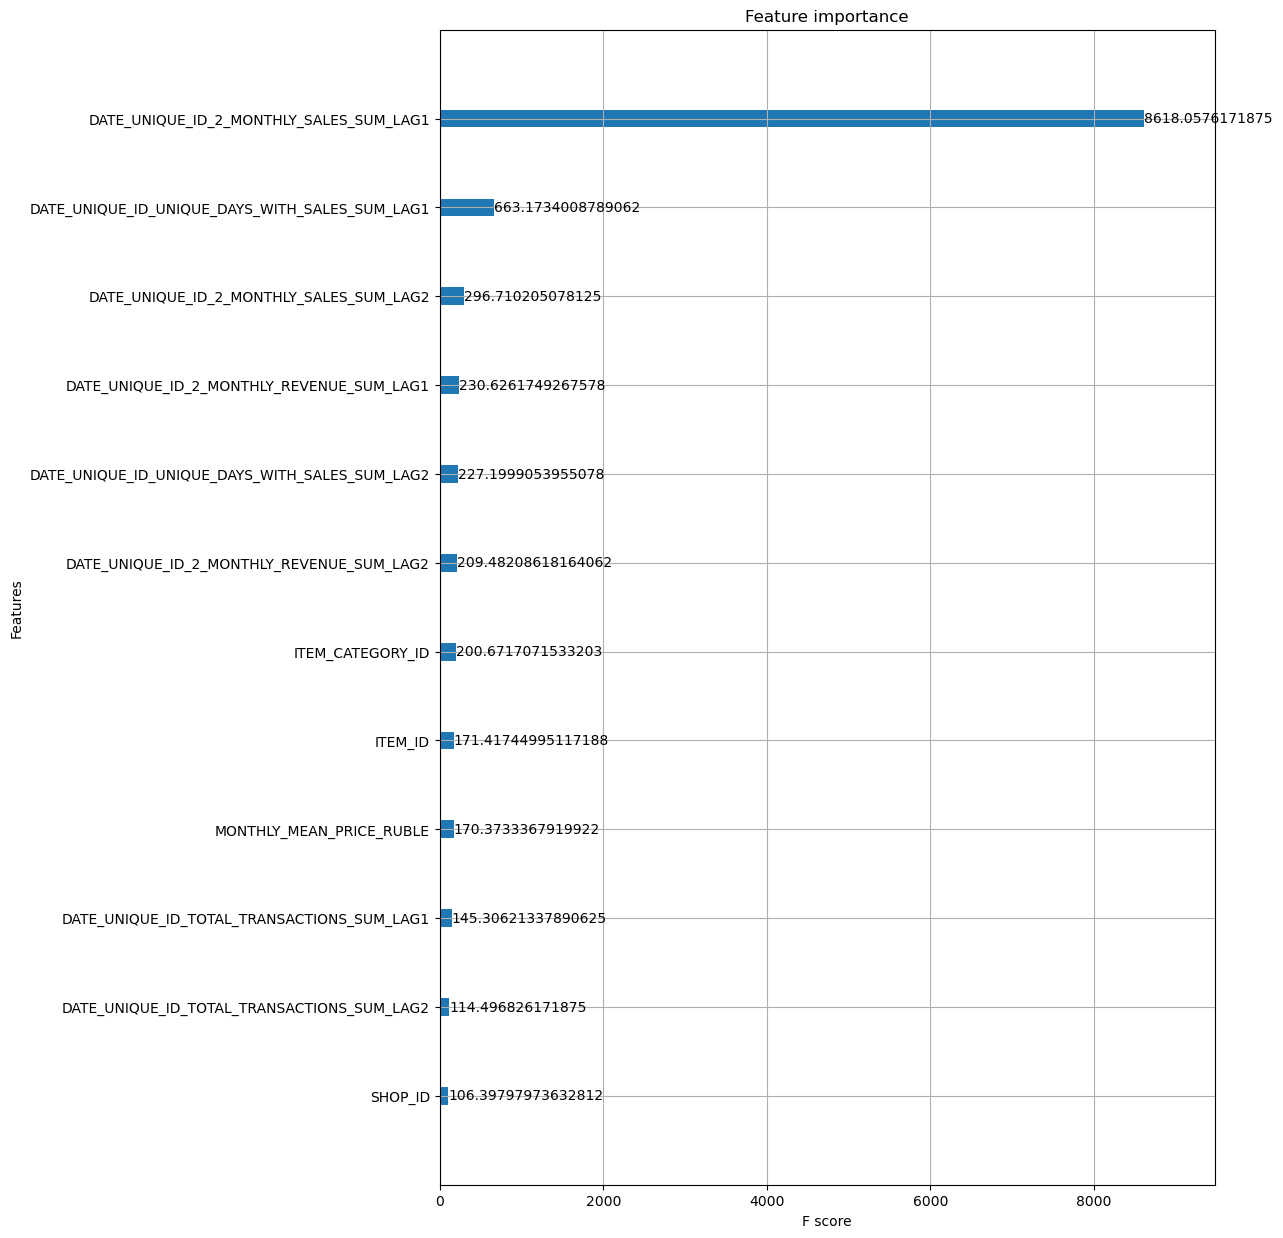

In [ ]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [ ]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

In [ ]:
if "SALES_PREDICTED" in X_test.columns:
    X_test.drop("SALES_PREDICTED", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["SALES_PREDICTED"] = np.clip(Y_test_predict, 0, 30)

In [ ]:
X_test.reset_index(inplace = True)

In [5507]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 5)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 5)).replace(".", "_")

In [5508]:
print("Resultado del rmse_train:",rmse_train)
print("Resultado del rmse_valida:",rmse_valida)

Resultado del rmse_train: 4_90813
Resultado del rmse_valida: 4_64388


In [3059]:
(
    X_test[["UNIQUE_ID", "SALES_PREDICTED"]]
    .rename(columns = {"UNIQUE_ID":"unique_id", "SALES_PREDICTED":"sales"})
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
2. Construir nuevas variables.
3. Probar estas variables en el modelo.
4. Guardar el score para ver la mejora o no (Kaggle Submit).
5. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
2. Darle más profundidad a los lags/shifts.
3. Implementar medias móviles (ojo variables autoexplicativas).
4. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
5. Añadir variables externas (relación rublo/dólar, festivos locales etc).
6. Probar otros algoritmos.
7. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)